# **Import**

In [ ]:
import pandas as pd
import json

import datasets
from datasets import load_metric, load_dataset, DatasetDict, Dataset


import sklearn
from sklearn.model_selection import train_test_split

from huggingface_hub import notebook_login

import transformers
from transformers.utils import send_example_telemetry 
from transformers import XLMRobertaForSequenceClassification, DataCollatorWithPadding, \
AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

import random

from tqdm import tqdm

import matplotlib.pyplot as plt


import torch
from torch.utils.data import DataLoader
import evaluate
import torch


import os
import warnings
import gc 

# **Setting the environment**

In [2]:
os.environ['HF_HOME'] = '../cache/misc'
os.environ['HF_DATASETS_CACHE'] = '../cache/datasets'
os.environ['TRANSFORMERS_CACHE'] = '../cache/models'

---

---

# **Loading the model**

In [3]:
model_path = "../models/second run - xlm-r - wiki-detox + measuring-hate-speech + ToLD + online_hs_recog + GermEval"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

---

# **Datasets**

**Load the data**

In [4]:
wiki = pd.read_csv("../datasets/wiki-detox-merged.csv")
measuring_hs = pd.read_csv("../datasets/measuring-hate-speech.csv")
ToLD = pd.read_csv("../datasets/ToLD-PT.csv")
online_hs_recog = pd.read_csv("../datasets/online-hate-speech-recog.csv")
GermEval = pd.read_csv("../datasets/GermEval-2018.csv")

In [5]:
all_data = [wiki, measuring_hs, ToLD, online_hs_recog, GermEval]

**Replacing [SEP] with a model specific separation token**

In [6]:
def replace_sep_token(df):
    tqdm.pandas()
    separator = '</s><s>'
    df['text'] = df['text'].progress_apply(lambda x: x.replace('[SEP]', separator))
    return df

In [7]:
repl_data = [replace_sep_token(df) for df in all_data]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8511/8511 [00:00<00:00, 874772.63it/s]


**Splitting data into train/test parts**

In [8]:
def split_data(df, test_size=0.2):
    train, test = sklearn.model_selection.train_test_split(df, test_size=test_size, random_state=42)
    return train, test

In [9]:
train_wiki, test_wiki = split_data(repl_data[0])
train_measuring_hs, test_measuring_hs = split_data(repl_data[1])
train_ToLD, test_ToLD = split_data(repl_data[2])
train_online_hs_recog, test_online_hs_recog = split_data(repl_data[3])
train_GermEval, test_GermEval = split_data(repl_data[4])

**Creating actual datasets**

In [10]:
def create_dataset(train, test):
    train_dataset = Dataset.from_pandas(train.rename_axis(index='index'))
    test_dataset = Dataset.from_pandas(test.rename_axis(index='index'))
    dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})
    return dataset

In [11]:
ds_wiki = create_dataset(train_wiki,test_wiki)
ds_measuring_hs = create_dataset(train_measuring_hs,test_measuring_hs)
ds_ToLD = create_dataset(train_ToLD, test_ToLD)
ds_online_hs_recog = create_dataset(train_online_hs_recog, test_online_hs_recog)
ds_GermEval = create_dataset(train_GermEval, test_GermEval)

---

# **Tokenizer**

**Load the tokenizer**

In [12]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast=True, cache_dir = './cache/models/')

**Data Collator**

In [13]:
data_collator = DataCollatorWithPadding(tokenizer)

**Define the tokenizing function**

In [14]:
def preprocess_data(dataset, tokenizer, cache_dir=None):
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

    # Check if the tokenized data is already cached
    if cache_dir is not None:
        cached_features_file = os.path.join(cache_dir, "cached_features")
        if os.path.exists(cached_features_file):
            tokenized_data = datasets.load_from_disk(cached_features_file)
            return tokenized_data

    # Tokenize the data
    tokenized_data = dataset.map(tokenize_function, batched=True)
    tokenized_data = tokenized_data.remove_columns(["index", "text"])
    tokenized_data = tokenized_data.rename_column("label", "labels")
    tokenized_data = tokenized_data.with_format("torch")

    # Cache the tokenized data if cache_dir is provided
    if cache_dir is not None:
        tokenized_data.save_to_disk(cached_features_file)

    return tokenized_data

In [15]:
wiki = preprocess_data(ds_wiki, tokenizer, cache_dir="wiki_cache")
measuring_hs = preprocess_data(ds_measuring_hs, tokenizer, cache_dir="measuring_hs_cache")
ToLD = preprocess_data(ds_ToLD, tokenizer, cache_dir="ToLD_cache")
online_hs_recog = preprocess_data(ds_online_hs_recog, tokenizer, cache_dir="online_hs_recog_cache")
GermEval = preprocess_data(ds_GermEval, tokenizer, cache_dir="GermEval_cache")

---


# **Load the metric**

In [ ]:
metric = load_metric('f1')

In [17]:
def compute_metrics(pred):
    predicted_labels = pred.predictions.argmax(axis=-1)
    true_labels = pred.label_ids
    accuracy = metric.compute(predictions=predicted_labels, references=true_labels)
    return accuracy

---

---

# **Trainer**

**Trainer's args**

In [18]:
batch_size = 32
steps = 5000

training_args = TrainingArguments(
    output_dir= '../checkpoints-xlmr-wiki',
    evaluation_strategy='steps',
    eval_steps=steps,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy='steps',
    save_steps=steps
    )

**One trainer for each dataset**

We also name it "evaluator" here

# **EVALUATION**

**wiki**

In [19]:
eval_wiki = Trainer(
    model=model,
    args=training_args,
    train_dataset=wiki['train'],
    eval_dataset=wiki['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

**measuring_hs**

In [20]:
eval_measuring_hs = Trainer(
    model=model,
    args=training_args,
    train_dataset=measuring_hs['train'],
    eval_dataset=measuring_hs['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

**ToLD**

In [21]:
eval_ToLD = Trainer(
    model=model,
    args=training_args,
    train_dataset=ToLD['train'],
    eval_dataset=ToLD['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

**online_hs_recog**

In [22]:
eval_online_hs_recog = Trainer(
    model=model,
    args=training_args,
    train_dataset=online_hs_recog['train'],
    eval_dataset=online_hs_recog['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

**GermEval** 

In [23]:
eval_GermEval = Trainer(
    model=model,
    args=training_args,
    train_dataset=GermEval['train'],
    eval_dataset=GermEval['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

# Evaluation time!

**Clear some space**

In [24]:
torch.cuda.empty_cache()
gc.collect()

1215

In [25]:
torch.cuda.empty_cache()
gc.collect()

0

**Evaluate**

In [ ]:
results_wiki = eval_wiki.evaluate()
results_wiki

In [ ]:
results_measuring_hs = eval_measuring_hs.evaluate()
results_measuring_hs

In [ ]:
results_ToLD = eval_ToLD.evaluate()
results_ToLD

In [ ]:
results_online_hs_recog = eval_online_hs_recog.evaluate()
results_online_hs_recog

In [ ]:
results_GermEval = eval_GermEval.evaluate()
results_GermEval

**Collect the f1 scores**

In [31]:
f1_values = {}

f1_values["wiki"] = results_wiki["eval_f1"]
f1_values["measuring_hs"] = results_measuring_hs["eval_f1"]
f1_values["ToLD"] = results_ToLD["eval_f1"]
f1_values["online_hs_recog"] = results_online_hs_recog["eval_f1"]
f1_values["GermEval"] = results_GermEval["eval_f1"]

**Plot the f1 scores**

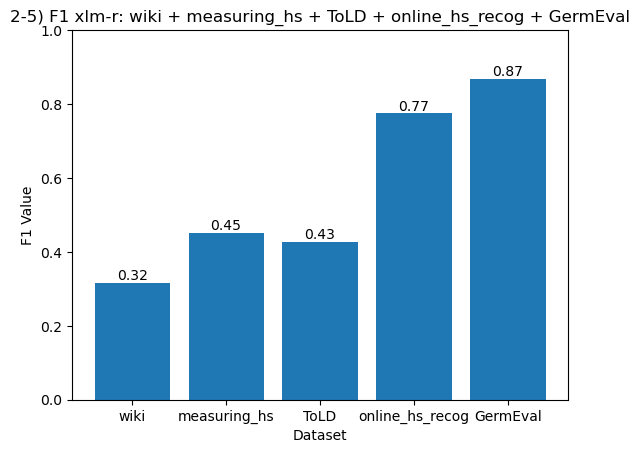

In [32]:
plt.bar(f1_values.keys(), f1_values.values())
plt.xlabel("Dataset")
plt.ylabel("F1 Value")
plt.title("2-5) F1 xlm-r: wiki + measuring_hs + ToLD + online_hs_recog + GermEval")
plt.ylim(0, 1)
for i, value in enumerate(f1_values.values()):
    plt.text(i, value, str(round(value, 2)), ha="center", va="bottom")
plt.show()

In [33]:
final_results = {"2-5) wiki + measuring_hs + ToLD + online_hs_recog + GermEval": f1_values}
file_path = "SECOND RUN - final_results.json"

with open(file_path) as file:
    existing_data = json.load(file)

existing_data.update(final_results)

with open(file_path, "w") as file:
    json.dump(existing_data, file)


#file_path = "SECOND RUN - final_results.json"
#final_results = {"2-1) xlm-r - wiki": f1_values}
#with open(file_path, "w") as file:
#    json.dump(final_results, file)

In [34]:
f1_values

{'wiki': 0.3157782002195507,
 'measuring_hs': 0.4506992492271456,
 'ToLD': 0.4273941460642228,
 'online_hs_recog': 0.7745262343689572,
 'GermEval': 0.8679962013295347}